# CAFA 5 protein function Prediction with TensorFlow

This notebook walks you through how to train a DNN model using TensorFlow on the CAFA 5 protein function Prediction dataset made available for this competition. 

The objective of the model is to predict the function(aka **GO term ID**) of a set of proteins based on their amino acid sequences and other data.


**Note** : This notebook runs without any GPU. This is because enabling GPUs leaves less RAM memory on the VM and the submission step needs a lot of memory. One point where this would impact is when training the model. With CPU it will take around 2 minutes while on GPU it would take around 30 seconds.

## About the Data

### Protein Sequence

Each protein is composed of dozens or hundreds of amino acids that are linked sequentially. Each amino acid in the sequence may be represented by a one-letter or three-letter code. Thus the sequence of a protein is often notated as a string of letters. 

<img src="https://cityu-bioinformatics.netlify.app/img/tools/protein/pro_seq.png" alt ="Sequence.png" style='width: 800px;' >

Image source - [https://cityu-bioinformatics.netlify.app/](https://cityu-bioinformatics.netlify.app/too2/new_proteo/pro_seq/)

The `train_sequences.fasta` made available for this competitions, contains the sequences for proteins with annotations (labelled proteins).

# Gene Ontology

We can define the functional properties of a proteins using Gene Ontology(GO). Gene Ontology (GO) describes our understanding of the biological domain with respect to three aspects:
1. Molecular Function (MF)
2. Biological Process (BP)
3. Cellular Component (CC)

Read more about Gene Ontology [here](http://geneontology.org/docs/ontology-documentation).

File `train_terms.tsv` contains the list of annotated terms (ground truth) for the proteins in `train_sequences.fasta`. In `train_terms.tsv` the first column indicates the protein's UniProt accession ID (unique protein id), the second is the `GO Term ID`, and the third indicates in which ontology the term appears. 

# Labels of the dataset

The objective of our model is to predict the terms (functions) of a protein sequence. One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a `GO Term ID`. Thus our model has to predict all the `GO Term ID`s for a protein sequence. This means that the task at hand is a multi-label classification problem. 

# Protein embeddings for train and test data

To train a machine learning model we cannot use the alphabetical protein sequences in`train_sequences.fasta` directly. They have to be converted into a vector format. In this notebook, we will use embeddings of the protein sequences to train the model. You can think of protein embeddings to be similar to word embeddings used to train NLP models.
<!-- Instead, to make calculations and data preparation easier we will use precalculated protein embeddings.
 -->
Protein embeddings are a machine-friendly method of capturing the protein's structural and functional characteristics, mainly through its sequence. One approach is to train a custom ML model to learn the protein embeddings of the protein sequences in the dataset being used in this notebook. Since this dataset represents proteins using amino-acid sequences which is a standard approach, we can use any publicly available pre-trained protein embedding models to generate the embeddings.

There are a variety of protein embedding models. To make data preparation easier, we have used the precalculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model in this notebook. The precalculated protein embeddings can be found [here](https://www.kaggle.com/datasets/sergeifironov/t5embeds). We have added this dataset to the notebook along with the dataset made available for the competition.

To add this to your enviroment, on the right side panel, click on `Add Data` and search for `t5embeds` (make sure that it's the correct [one](https://www.kaggle.com/datasets/sergeifironov/t5embeds)) and then click on the `+` beside it.



# Import the Required Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Required for progressbar widget
import progressbar

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow v" + tf.__version__)
print("Numpy v" + np.__version__)

TensorFlow v2.11.0
Numpy v1.23.5


# Load the Dataset

First we will load the file `train_terms.tsv` which contains the list of annotated terms (functions) for the proteins. We will extract the labels aka `GO term ID` and create a label dataframe for the protein embeddings.

In [3]:
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


`train_terms` dataframe is composed of 3 columns and 5363863 entries. We can see all 3 dimensions of our dataset by printing out the first 5 entries using the following code:

In [4]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


If we look at the first entry of `train_terms.tsv`, we can see that it contains protein id(`A0A009IHW8`), the GO term(`GO:0008152`) and its aspect(`BPO`). 

# Loading the protein embeddings


We will now load the pre calculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

If the `tfembeds` is not yet on the input data of the notebook, you can add it to your enviromentby clicking on `Add Data` and search for `t5embeds` (make sure that it's the correct [one](https://www.kaggle.com/datasets/sergeifironov/t5embeds) ) and then click on the `+` beside it.

The protein embeddings to be used for training are recorded in `train_embeds.npy` and the corresponding protein ids are available in `train_ids.npy`.

First, we will load the protein ids of the protein embeddings in the train dataset contained in `train_ids.npy` into a numpy array.

In [5]:
train_protein_ids = np.load('/kaggle/input/t5embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


The `train_protein_ids` array consists of 142246 protein_ids. Let us print out the first 5 entries using the following code:

In [6]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

<!-- Now, we will load`train_embeds.py` which contains the pre-calculated embeddings of the proteins in the train dataset. with protein_ids (`id`s we loaded previously from the **train_ids.npy**) into a numpy array. This array now contains the precalculated embeddings for the protein_ids( Ids we loaded above from **train_ids.npy**) needed for training. -->

After loading the files as numpy arrays, we will convert them into Pandas dataframe.

Each protein embedding is a vector of length 1024. We create the resulting dataframe such that there are 1024 columns to represent the values in each of the 1024 places in the vector.

In [7]:
train_embeddings = np.load('/kaggle/input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


The `train_df` dataframe which contains the embeddings is composed of 1024 columns and 142246 entries. We can see all 1024 dimensions(results will be truncated since column length is too long)  of our dataset by printing out the first 5 entries using the following code:

In [8]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Prepare the dataset

Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

First we will extract all the needed labels(`GO term ID`) from `train_terms.tsv` file. There are more than 40,000 labels. In order to simplify our model, we will choose the most frequent 1500 `GO term ID`s as labels.

Let's plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

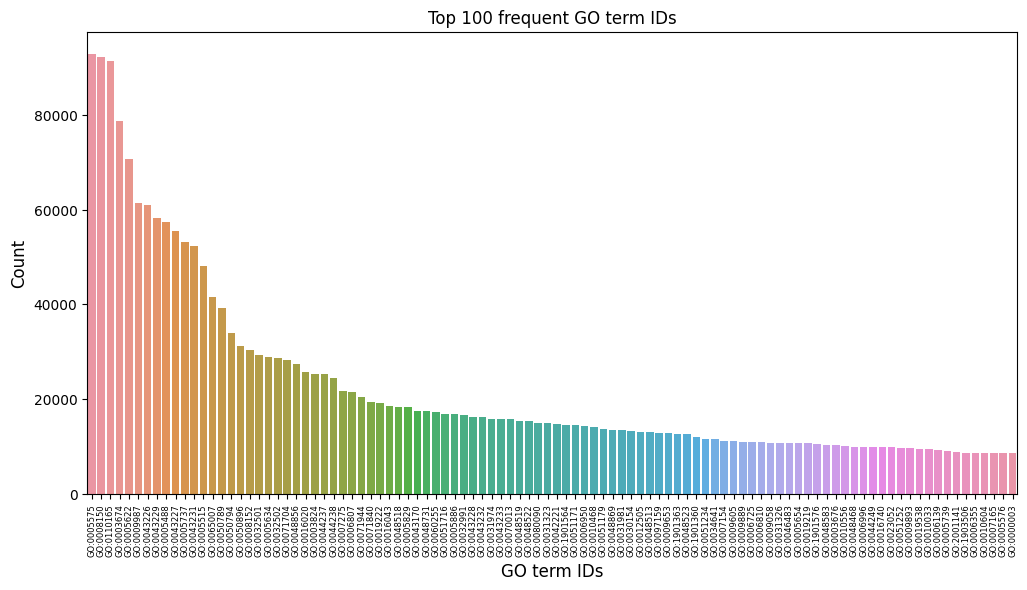

In [9]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

We will now save the first 1500 most frequent GO term Ids into a list.

In [10]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

Next, we will create a new dataframe by filtering the train terms with the selected `GO Term ID`s.

In [11]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

Let us plot the aspect values in the new **train_terms_updated** dataframe using a pie chart.

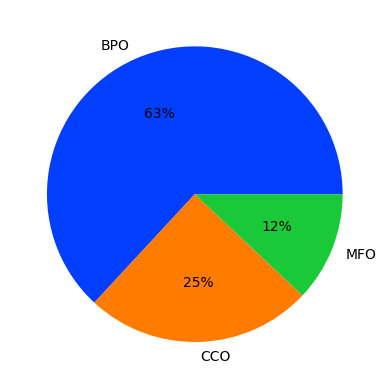

In [12]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

As you can see, majority of the `GO term Id`s have BPO(Biological Process Ontology) as their aspect.

Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0.
First, we will create a numpy array `train_labels` of required size for the labels. To update the `train_labels` array with the appropriate values, we will loop through the label list.

In [13]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)
    
    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar 
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

[========================================================================] 100%


(142246, 1500)


The final labels dataframe (`label_df`) is composed of 1500 columns and 142246 entries. We can see all 1500 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [14]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training

Next, we will use Tensorflow to train a Deep Neural Network with the protein embeddings.

In [15]:
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

Epoch 1/5
28/28 [==============================] - 29s 956ms/step - loss: 0.1920 - binary_accuracy: 0.9431 - auc: 0.6895
Epoch 2/5
28/28 [==============================] - 27s 947ms/step - loss: 0.0782 - binary_accuracy: 0.9801 - auc: 0.8322
Epoch 3/5
28/28 [==============================] - 26s 922ms/step - loss: 0.0736 - binary_accuracy: 0.9803 - auc: 0.8610
Epoch 4/5
28/28 [==============================] - 26s 938ms/step - loss: 0.0697 - binary_accuracy: 0.9805 - auc: 0.8864
Epoch 5/5
28/28 [==============================] - 27s 950ms/step - loss: 0.0668 - binary_accuracy: 0.9807 - auc: 0.9025


# Plot the model's loss and accuracy for each epoch

<AxesSubplot: title={'center': 'Accuracy'}>

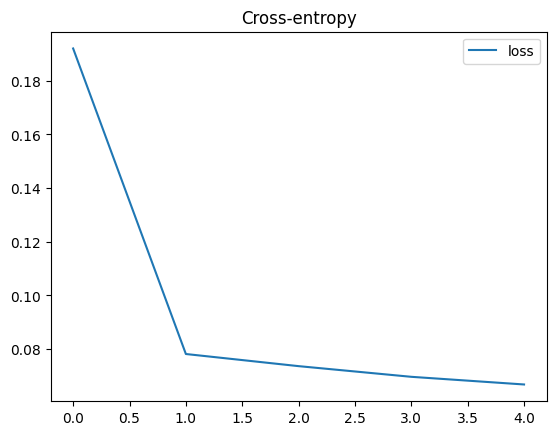

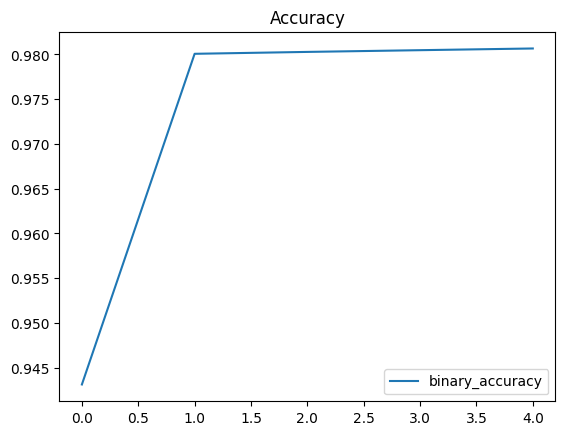

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Submission

For submission we will use the protein embeddings of the test data created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

In [17]:
test_embeddings = np.load('/kaggle/input/t5embeds/test_embeds.npy')

# Convert test_embeddings to dataframe
column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


The `test_df` is composed of 1024 columns and 141865 entries. We can see all 1024 dimensions(results will be truncated since column length is too long) of our dataset by printing out the first 5 entries using the following code:

In [18]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


We will now use the model to make predictions on the test embeddings. 

In [19]:
predictions =  model.predict(test_df)

4434/4434 [==============================] - 25s 6ms/step


From the predictions we will create the submission data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [ ]:
# Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary

df_submission = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('/kaggle/input/t5embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]   

df_submission['Protein Id'] = l
df_submission['GO Term Id'] = labels * predictions.shape[0]
df_submission['Prediction'] = predictions.ravel()
df_submission.to_csv("submission.tsv",header=False, index=False, sep="\t")

In [ ]:
df_submission